<a href="https://colab.research.google.com/github/cds-swinburne/Synergistic-Eigenanalysis-Covariance-Hessian/blob/main/Illustrative_case_study_WBCD_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustrative case study: <font color=#FF5F1F>Wisconsin Breast Cancer dataset</font>





In [ ]:
# Import 3rd party dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from imblearn.over_sampling import SMOTE
from torch.autograd.functional import hessian
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    confusion_matrix,
)
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
!pip install umap-learn
import umap.umap_ as umap
import warnings
from IPython.display import display, HTML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Suppressing Warnings and Adjusting Display Width
# We ignore any warning messages that might arise during execution to maintain clean output.
# Additionally, we adjust the display width to ensure that the content is fully visible within the Jupyter notebook.

warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load the data, exploratory data analysis, and data splitting

In this demo we will use a preprocessed version of [Wisconsin Breast Cancer dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data).

In [ ]:
# Load the data

# https://drive.google.com/file/d/1ZuVKfaagT72o7-0TWeWd49yK6gmEZbb3/view?usp=sharing

!wget -O "WBCD_(original).csv" "https://drive.google.com/uc?export=download&id=1ZuVKfaagT72o7-0TWeWd49yK6gmEZbb3"
original_dataset_df = pd.read_csv("WBCD_(original).csv")

--2024-10-02 15:35:34--  https://drive.google.com/uc?export=download&id=1ZuVKfaagT72o7-0TWeWd49yK6gmEZbb3
Resolving drive.google.com (drive.google.com)... 172.217.0.78, 2607:f8b0:4025:810::200e
Connecting to drive.google.com (drive.google.com)|172.217.0.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ZuVKfaagT72o7-0TWeWd49yK6gmEZbb3&export=download [following]
--2024-10-02 15:35:34--  https://drive.usercontent.google.com/download?id=1ZuVKfaagT72o7-0TWeWd49yK6gmEZbb3&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.65.97, 2607:f8b0:4025:804::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.65.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125204 (122K) [application/octet-stream]
Saving to: ‘WBCD_(original).csv’

WBCD_(original).csv 100%[===================>] 122.27K  --.-KB/s    in 0.03

In [ ]:
original_dataset_df.drop(original_dataset_df.columns[[-1, 0]], axis=1, inplace=True) # Remove the ID column
diagnosis_col = original_dataset_df['diagnosis']  # Extract the 'diagnosis' column
original_dataset_df.drop(columns=['diagnosis'], inplace=True)  # Remove the 'diagnosis' column from the DataFrame
original_dataset_df['diagnosis'] = diagnosis_col  # Add the 'diagnosis' column back to the DataFrame as the last column

In [ ]:
diagnosis_mapping = {'B': 0, 'M': 1}  # Mapping of 'B' to 0 and 'M' to 1
original_dataset_df['diagnosis'] = original_dataset_df['diagnosis'].map(diagnosis_mapping)

In [ ]:
# Define the lower and upper bounds for each predictor attribute using 1.5 IQR rule
Q1 = original_dataset_df.quantile(0.25)
Q3 = original_dataset_df.quantile(0.75)
IQR = Q3 - Q1
lower_bounds = Q1 - 1.5 * IQR
upper_bounds = Q3 + 1.5 * IQR

# Cap each predictor attribute using the lower and upper bounds
for predictor in original_dataset_df.columns[:-1]:
    original_dataset_df[predictor] = original_dataset_df[predictor].clip(lower=lower_bounds[predictor], upper=upper_bounds[predictor])

In [ ]:
# Print the unnormalized dataset
original_dataset_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,0.2419,0.07871,...,17.33,184.60,1937.05,0.16220,0.62695,0.7119,0.2654,0.41915,0.11890,1
1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1937.05,0.12380,0.18660,0.2416,0.1860,0.27500,0.08902,1
2,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.00,0.14440,0.42450,0.4504,0.2430,0.36130,0.08758,1
3,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,0.2464,0.07875,...,26.50,98.87,567.70,0.19010,0.62695,0.6869,0.2575,0.41915,0.12301,1
4,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.00,0.13740,0.20500,0.4000,0.1625,0.23640,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1326.3,0.111000,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,1937.05,0.14100,0.21130,0.4107,0.2216,0.20600,0.07115,1
565,20.13,28.25,131.20,1261.0,0.097800,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.00,0.11660,0.19220,0.3215,0.1628,0.25720,0.06637,1
566,16.60,28.08,108.30,858.1,0.084550,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.00,0.11390,0.30940,0.3403,0.1418,0.22180,0.07820,1
567,20.60,29.33,140.10,1265.0,0.117800,0.22862,0.28241,0.15200,0.2397,0.07016,...,39.42,184.60,1821.00,0.16500,0.62695,0.7855,0.2650,0.40870,0.12301,1


In [ ]:
# Generate descriptive statistics for the unnormalized dataset

original_dataset_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.062916,19.254736,91.543787,639.765202,0.096266,0.103222,0.086937,0.048552,0.180734,0.062604,...,25.648453,106.705369,849.907821,0.132209,0.249883,0.268754,0.114606,0.287616,0.083342,0.372583
std,3.340025,4.187510,23.047218,305.343508,0.013685,0.049386,0.073900,0.037633,0.026067,0.006418,...,6.054406,31.957777,475.645240,0.022320,0.142851,0.197461,0.065732,0.053868,0.015993,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.057975,0.019380,0.000000,0.000000,0.111200,0.049960,...,12.020000,50.410000,185.200000,0.072500,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,21.900000,30.245000,147.495000,1326.300000,0.133695,0.228620,0.282410,0.154535,0.246400,0.078750,...,42.680000,187.335000,1937.050000,0.190100,0.626950,0.785500,0.291000,0.419150,0.123010,1.000000


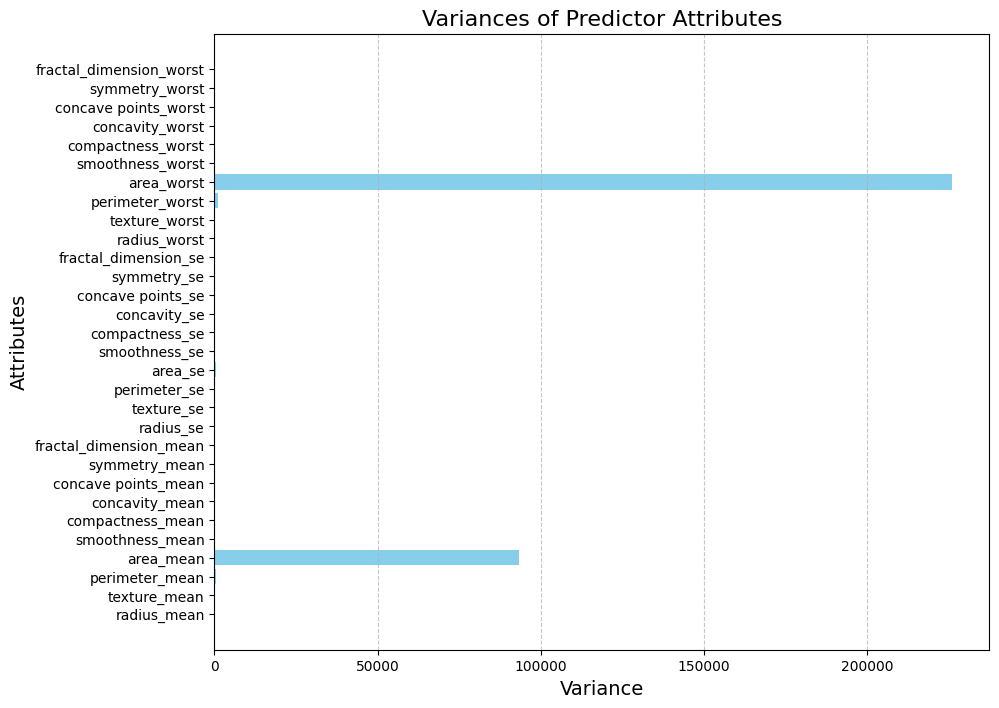

In [ ]:

# Calculate the variances of the predictor attributes (all attributes except the last one)
variances = original_dataset_df.iloc[:, :-1].var()  # Exclude the last column

# Set up the plot
plt.figure(figsize=(10, 8))

# Create a horizontal bar plot
plt.barh(variances.index, variances.values, color='skyblue')

# Add labels and title
plt.xlabel('Variance', fontsize=14)
plt.ylabel('Attributes', fontsize=14)
plt.title('Variances of Predictor Attributes', fontsize=16)

# Show the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: add gridlines
plt.show()


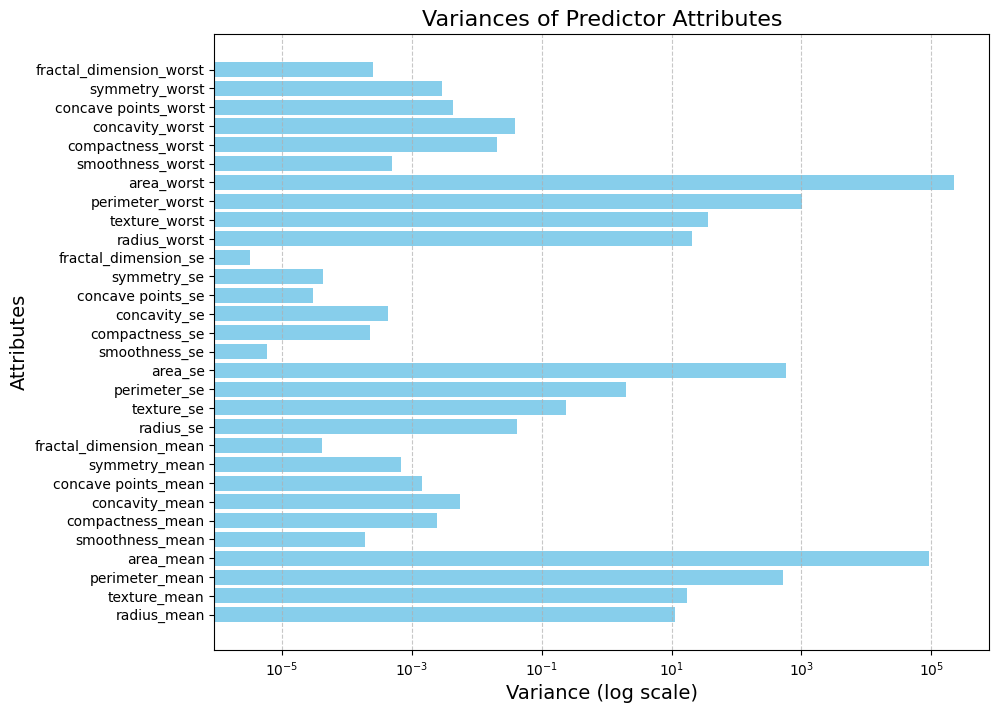

In [ ]:
# Set up the plot
plt.figure(figsize=(10, 8))

# Create a horizontal bar plot
plt.barh(variances.index, variances.values, color='skyblue')

# Set the y-axis to log scale
plt.xscale('log')

# Add labels and title
plt.xlabel('Variance (log scale)', fontsize=14)
plt.ylabel('Attributes', fontsize=14)
plt.title('Variances of Predictor Attributes', fontsize=16)

# Show the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: add gridlines
plt.show()

In [ ]:
# Create a copy of the original DataFrame to store normalized values
dataset_df = original_dataset_df.copy()

# Z-normalize each predictor attribute
for predictor in original_dataset_df.columns[:-1]:
    mean = dataset_df[predictor].mean()
    std_dev = dataset_df[predictor].std()

    # Apply Z-normalization
    dataset_df[predictor] = (dataset_df[predictor] - mean) / std_dev

In [ ]:
# Print the data table
dataset_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.175765,-2.119335,1.356182,1.183044,1.617438,2.539170,2.645094,2.618669,2.346470,2.509500,...,-1.373950,2.437423,2.285616,1.343665,2.639583,2.244217,2.294058,2.441770,2.223290,1
1,1.948215,-0.354563,1.794412,2.247419,-0.842254,-0.497751,-0.000497,0.574439,0.017867,-0.924636,...,-0.369723,1.630108,2.285616,-0.376766,-0.442998,-0.137513,1.086129,-0.234202,0.355002,1
2,1.684743,0.476480,1.668584,1.844594,0.974381,1.147670,1.494761,2.108475,1.003783,-0.407334,...,-0.019565,1.432973,1.806162,0.546173,1.222372,0.919909,1.953282,1.367854,0.264964,1
3,-0.791286,0.268719,-0.605877,-0.830754,2.735115,2.539170,2.090157,1.505277,2.519101,2.515733,...,0.140649,-0.245179,-0.593316,2.593666,2.639583,2.117610,2.173873,2.441770,2.480274,1
4,1.864383,-1.173665,1.889869,2.152444,0.294787,0.598926,1.502880,1.481362,0.006358,-0.588078,...,-1.482962,1.423586,1.524439,0.232553,-0.314193,0.664669,0.728618,-0.950765,-0.410321,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.244620,0.748718,2.189254,2.248401,1.076686,0.256721,2.123987,2.400773,-0.312051,-0.993194,...,0.124132,1.858534,2.285616,0.393844,-0.270091,0.718857,1.627719,-1.515105,-0.762345,1
565,1.816479,2.148117,1.720651,2.034544,0.112101,0.003611,0.772166,1.311563,-0.212308,-1.133426,...,2.081385,1.511201,1.852415,-0.699347,-0.403797,0.267123,0.733182,-0.564638,-1.061221,1
566,0.759601,2.107520,0.727038,0.715046,-0.856138,-0.018663,0.075416,0.118719,-0.833781,-0.954240,...,1.399237,0.625658,0.576253,-0.820315,0.416638,0.362331,0.413705,-1.221797,-0.321534,1
567,1.957196,2.406027,2.106815,2.047644,1.573593,2.539170,2.645094,2.748874,2.262073,1.177292,...,2.274632,2.437423,2.041631,1.469113,2.639583,2.616948,2.287972,2.247778,2.480274,1


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

In [ ]:
# Generate descriptive statistics for the dataset

dataset_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,569.000000
mean,2.497514e-16,3.309206e-16,-3.871147e-16,8.741299e-17,1.748260e-16,-1.248757e-17,8.741299e-17,1.248757e-17,-3.746271e-17,1.963670e-15,...,-3.871147e-16,4.120898e-16,8.741299e-17,3.246768e-16,3.746271e-17,-6.243785e-17,2.247763e-16,-2.872141e-16,-7.492542e-17,0.372583
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.483918
min,-2.120318e+00,-2.279334e+00,-2.071998e+00,-1.625269e+00,-2.798096e+00,-1.697697e+00,-1.176405e+00,-1.290160e+00,-2.667508e+00,-1.970146e+00,...,-2.250998e+00,-1.761555e+00,-1.397487e+00,-2.675156e+00,-1.558216e+00,-1.361043e+00,-1.743529e+00,-2.434013e+00,-1.769645e+00,0.000000
25%,-7.074546e-01,-7.366516e-01,-7.104453e-01,-7.187485e-01,-7.231422e-01,-7.755647e-01,-7.764069e-01,-7.504705e-01,-7.225297e-01,-7.641476e-01,...,-7.545668e-01,-7.070382e-01,-7.034819e-01,-6.993474e-01,-7.188101e-01,-7.811828e-01,-7.557349e-01,-6.908719e-01,-7.429619e-01,0.000000
50%,-2.074582e-01,-9.904128e-02,-2.301270e-01,-2.903785e-01,-2.893319e-02,-2.144694e-01,-3.436618e-01,-3.999780e-01,-5.885845e-02,-1.658226e-01,...,-3.938511e-02,-2.830412e-01,-3.435498e-01,-4.074466e-02,-2.658909e-01,-2.129707e-01,-2.232725e-01,-1.005431e-01,-2.064855e-01,0.000000
75%,5.140933e-01,6.078226e-01,5.448038e-01,4.681115e-01,6.601606e-01,5.503293e-01,5.921935e-01,6.762121e-01,5.741228e-01,5.478046e-01,...,6.724932e-01,5.849791e-01,4.921571e-01,6.178581e-01,6.245470e-01,5.780697e-01,7.118836e-01,5.621847e-01,5.463323e-01,1.000000
max,2.346415e+00,2.624534e+00,2.427678e+00,2.248401e+00,2.735115e+00,2.539170e+00,2.645094e+00,2.816236e+00,2.519101e+00,2.515733e+00,...,2.813083e+00,2.523005e+00,2.285616e+00,2.593666e+00,2.639583e+00,2.616948e+00,2.683516e+00,2.441770e+00,2.480274e+00,1.000000


#### <font color=#FF5F1F><b>Figure A</b></font>

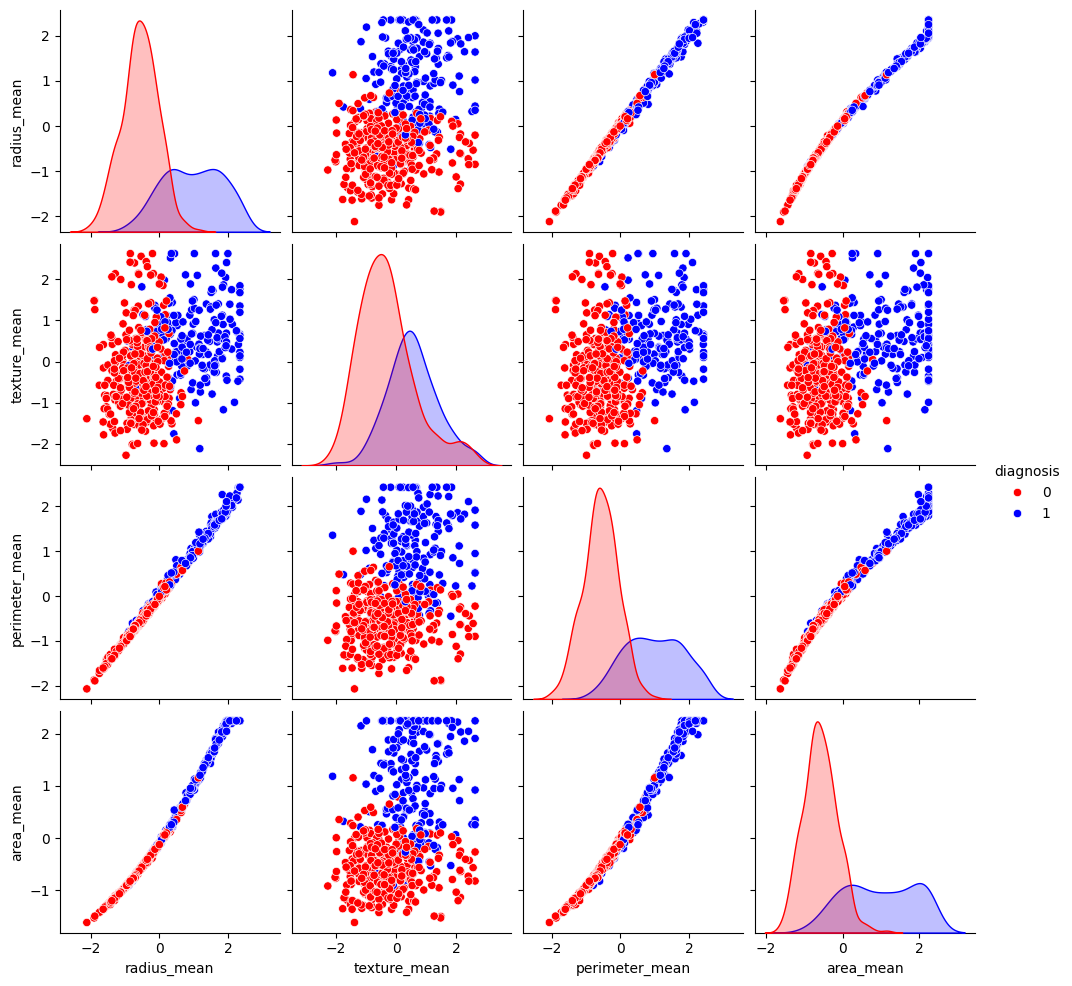

In [ ]:
# Select the first 5 predictor attributes
subset_attributes = dataset_df.iloc[:, :4]

# Add the 'diagnosis' column for hue
subset_attributes['diagnosis'] = dataset_df['diagnosis']

# Create the pairplot with the subset of attributes
sns.pairplot(subset_attributes, hue="diagnosis", palette={0: 'red', 1: 'blue'})
plt.show()


In [ ]:
# Create a column index map for predictor attributes
# The predictor_columns list contains all column names except for the "diagnosis" column,
# which corresponds to the target variable. We create a column_index_map dictionary
# to associate each predictor attribute with its corresponding index (column number).
# This mapping will be useful for further data manipulation and model building.

predictor_columns = [col for col in dataset_df.columns if col != "diagnosis"]
column_index_map = {}
for i, col_name in enumerate(predictor_columns):
    column_index_map[i] = col_name

In [ ]:
# Split original dataset into training and test sets
original_train_df, original_test_df = train_test_split(original_dataset_df, test_size=0.3, random_state=42)

# Separate target variable from features
original_train_X = original_train_df.drop("diagnosis", axis=1)

In [ ]:
# Split dataset into training and test sets
train_df, test_df = train_test_split(dataset_df, test_size=0.3, random_state=42)

# Separate target variable from features
train_y = train_df["diagnosis"]
train_X = train_df.drop("diagnosis", axis=1)
y_test = test_df["diagnosis"]
X_test = test_df.drop("diagnosis", axis=1)

## Covariance matrix and its eigenanalysis

The equation for the covariance matrix:

$$\text{Cov}(\theta_1, \theta_2) = \frac{1}{n-1} \sum_{i=1}^{n} (\theta_{1i} - \bar{\theta}_1)(\theta_{2i} - \bar{\theta}_2)$$

where $ \theta_1 $ and $ \theta_2 $ are random variables, $ \theta_{1i} $ and $ \theta_{2i} $ are the corresponding observations, $ \bar{\theta}_1 $ and $ \bar{\theta}_2 $ are the sample means, and $ n $ is the number of observations. This equation calculates the covariance between two random variables $ \theta_1 $ and $ \theta_2 $ by taking the average of the product of their deviations from their respective means.

By performing eigenanalysis on the covariance matrix, we can obtain the eigenvalues and eigenvectors. The eigenvectors represent the principal directions or axes of the parameter space, while the eigenvalues correspond to the variances of the parameters along those directions. The eigenvector associated with the largest eigenvalue represents the leading parameter direction with the highest variance.

In [ ]:
# Calculating the covariance matrix
original_covariance_matrix = original_train_X.cov()

# Calculating the covariance matrix
covariance_matrix = train_X.cov()

#### <font color=#FF5F1F><b>Figure B</b></font>

### Covariance matrices of unnormalized WBCD dataset

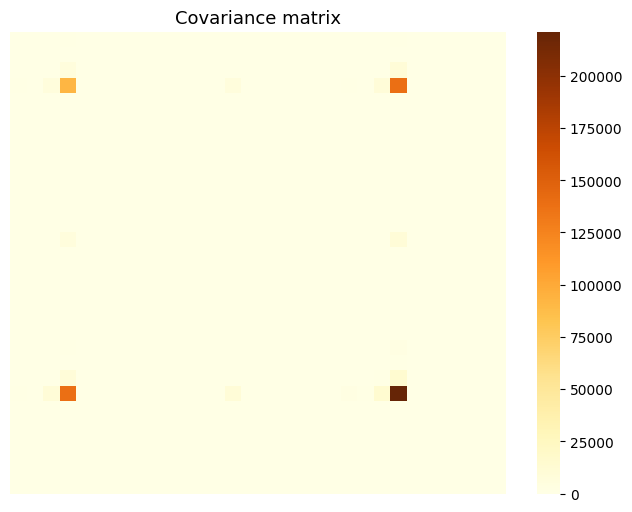

In [ ]:
# Visualize the covariance matrix as a heatmap
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8, 6))
sns.heatmap(original_covariance_matrix, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Covariance matrix', fontsize=13)
plt.show()

In [ ]:
# Split original_train_X into train_X_class0 and train_X_class1 based on the values in train_y
original_train_X_class0 = original_train_X[train_y == 0]
original_train_X_class1 = original_train_X[train_y == 1]

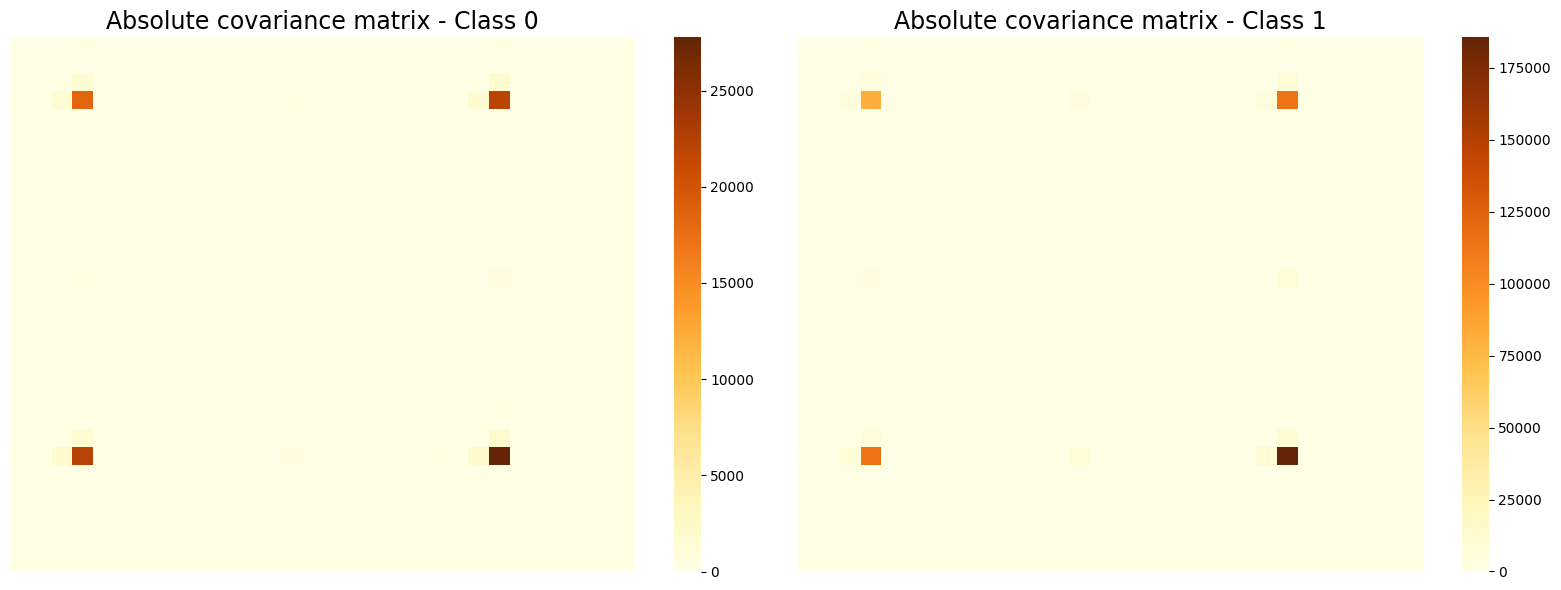

In [ ]:
# Calculate the covariance matrices for class 0 and class 1
cov_matrix_class0 = np.cov(original_train_X_class0, rowvar=False)
cov_matrix_class1 = np.cov(original_train_X_class1, rowvar=False)

# Take the absolute values of the covariance matrices
abs_cov_matrix_class0 = np.abs(cov_matrix_class0)
abs_cov_matrix_class1 = np.abs(cov_matrix_class1)

# Set up the matplotlib figure
plt.figure(figsize=(16, 6))

# Plot the absolute covariance matrix for class 0
plt.subplot(1, 2, 1)
sns.heatmap(abs_cov_matrix_class0, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Absolute covariance matrix - Class 0', fontsize=17)

# Plot the absolute covariance matrix for class 1
plt.subplot(1, 2, 2)
sns.heatmap(abs_cov_matrix_class1, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Absolute covariance matrix - Class 1', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()

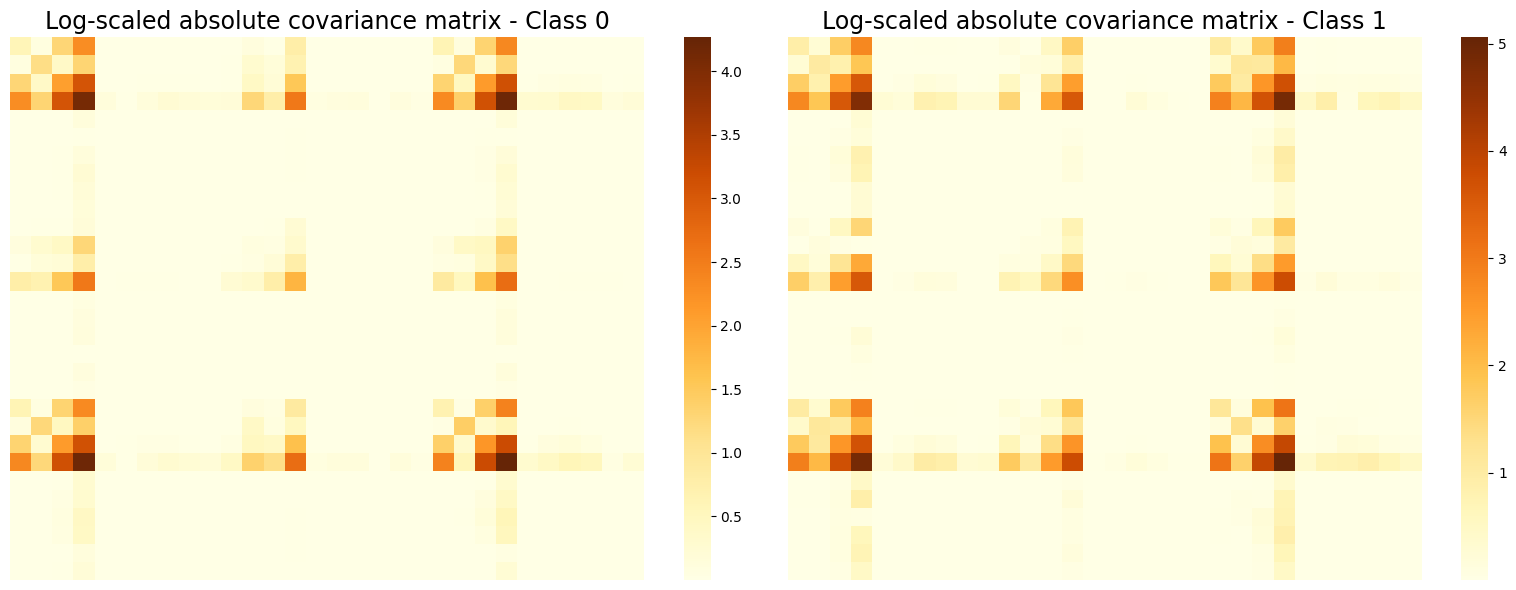

In [ ]:
# Apply logarithm (adding a small constant to avoid log(0))
log_cov_matrix_class0 = np.log1p(abs_cov_matrix_class0)/np.log1p(10)  # log(1 + x)
log_cov_matrix_class1 = np.log1p(abs_cov_matrix_class1)/np.log1p(10)

# Set up the matplotlib figure
plt.figure(figsize=(16, 6))

# Plot the log-scaled covariance matrix for class 0
plt.subplot(1, 2, 1)
sns.heatmap(log_cov_matrix_class0, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Log-scaled absolute covariance matrix - Class 0', fontsize=17)

# Plot the log-scaled covariance matrix for class 1
plt.subplot(1, 2, 2)
sns.heatmap(log_cov_matrix_class1, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Log-scaled absolute covariance matrix - Class 1', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()

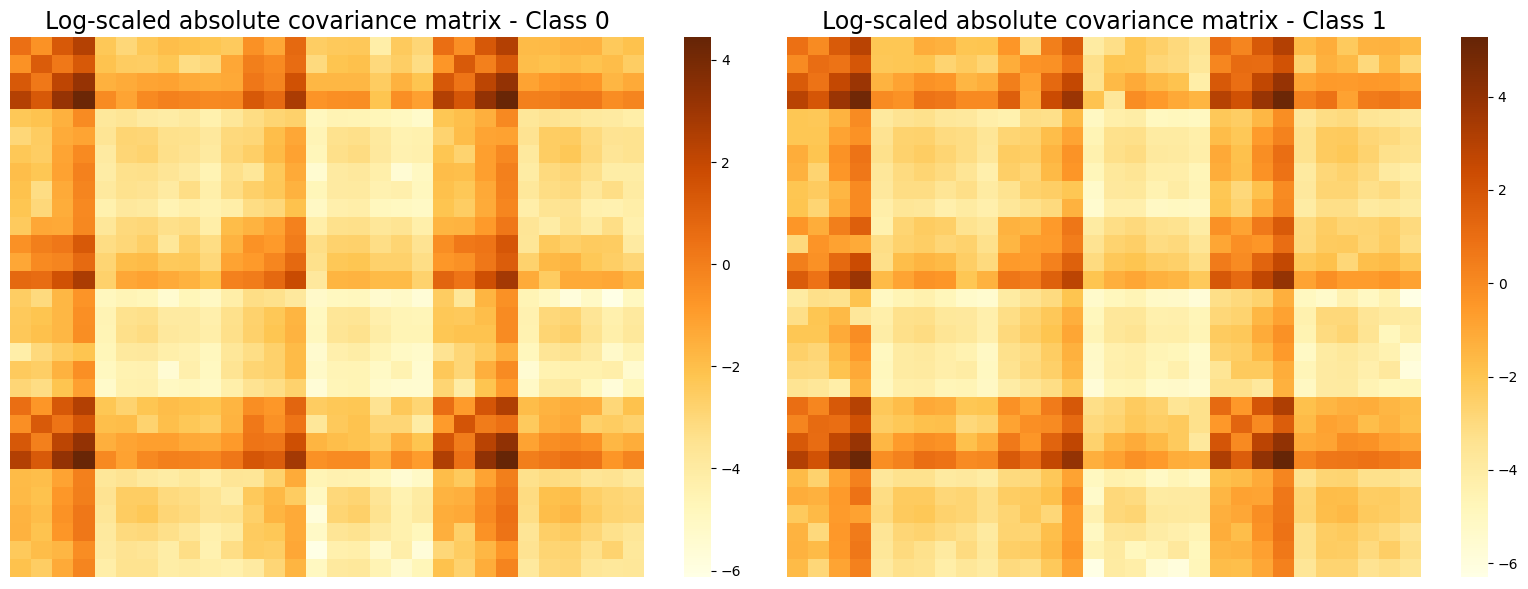

In [ ]:
# Apply logarithm (adding a small constant to avoid log(0))
log_cov_matrix_class0 = np.log(abs_cov_matrix_class0)/np.log(10)  # log(1 + x)
log_cov_matrix_class1 = np.log(abs_cov_matrix_class1)/np.log(10)

# Set up the matplotlib figure
plt.figure(figsize=(16, 6))

# Plot the log-scaled covariance matrix for class 0
plt.subplot(1, 2, 1)
sns.heatmap(log_cov_matrix_class0, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Log-scaled absolute covariance matrix - Class 0', fontsize=17)

# Plot the log-scaled covariance matrix for class 1
plt.subplot(1, 2, 2)
sns.heatmap(log_cov_matrix_class1, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Log-scaled absolute covariance matrix - Class 1', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()

### Covariance matrices of normalized WBCD dataset

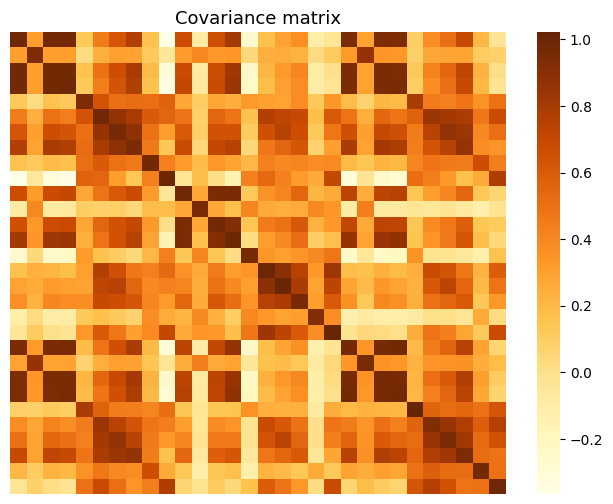

In [ ]:
# Visualize the covariance matrix as a heatmap
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8, 6))
sns.heatmap(covariance_matrix, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Covariance matrix', fontsize=13)
plt.show()


In [ ]:
# Split train_X into train_X_class0 and train_X_class1 based on the values in train_y
train_X_class0 = train_X[train_y == 0]
train_X_class1 = train_X[train_y == 1]

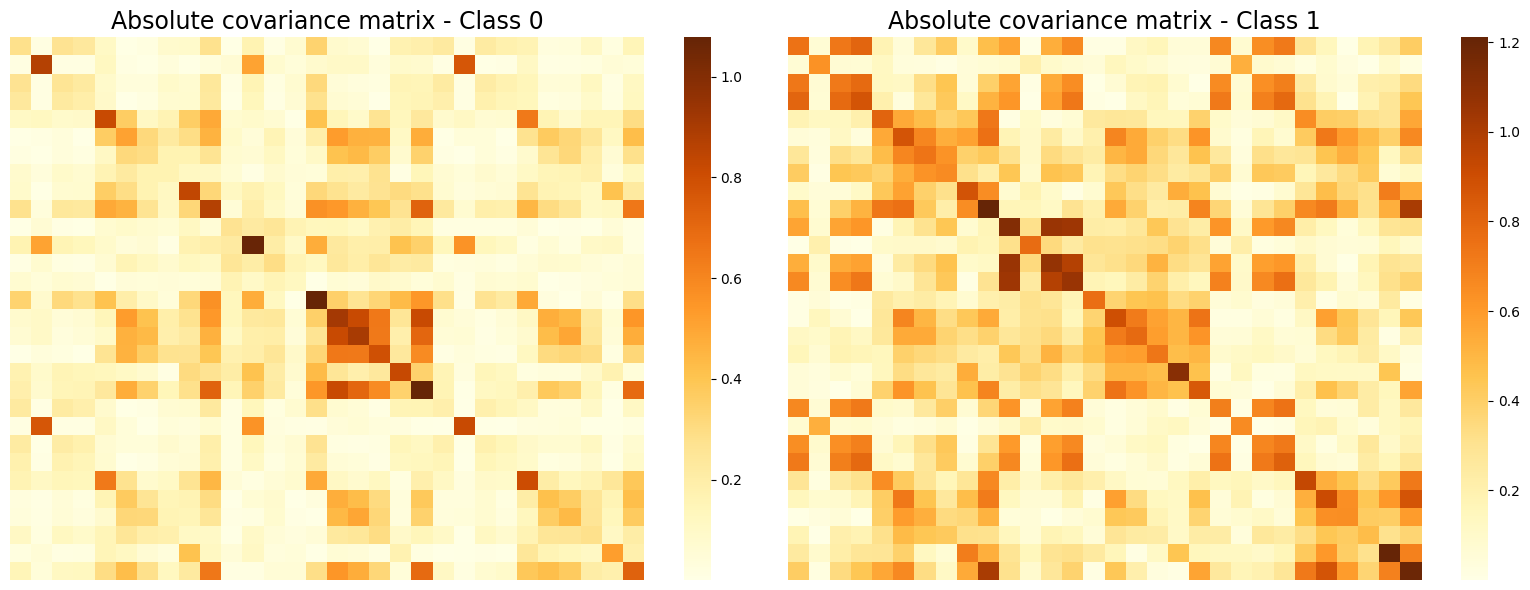

In [ ]:
# Calculate the covariance matrices for class 0 and class 1
cov_matrix_class0 = np.cov(train_X_class0, rowvar=False)
cov_matrix_class1 = np.cov(train_X_class1, rowvar=False)

# Take the absolute values of the covariance matrices
abs_cov_matrix_class0 = np.abs(cov_matrix_class0)
abs_cov_matrix_class1 = np.abs(cov_matrix_class1)

# Set up the matplotlib figure
plt.figure(figsize=(16, 6))

# Plot the absolute covariance matrix for class 0
plt.subplot(1, 2, 1)
sns.heatmap(abs_cov_matrix_class0, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Absolute covariance matrix - Class 0', fontsize=17)

# Plot the absolute covariance matrix for class 1
plt.subplot(1, 2, 2)
sns.heatmap(abs_cov_matrix_class1, annot=False, cmap='YlOrBr', fmt='.2f', xticklabels=False, yticklabels=False)
plt.title('Absolute covariance matrix - Class 1', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the average of diagonal and non-diagonal elements for a matrix
def average_diagonal_and_non_diagonal(matrix):
    # Get the diagonal elements
    diagonal_elements = np.diag(matrix)
    # Calculate the mean of diagonal elements
    avg_diagonal = np.mean(diagonal_elements)

    # Get all elements and subtract the diagonal elements
    all_elements = matrix.flatten()
    non_diagonal_elements = all_elements[~np.isin(all_elements, diagonal_elements)]
    # Calculate the mean of non-diagonal elements
    avg_non_diagonal = np.mean(non_diagonal_elements)

    return avg_diagonal, avg_non_diagonal

# Compute averages for the absolute covariance matrix of class 0
avg_diag_class0, avg_non_diag_class0 = average_diagonal_and_non_diagonal(abs_cov_matrix_class0)
print(f"Class 0 - Average Diagonal: {avg_diag_class0:.4f}, Average Non-Diagonal: {avg_non_diag_class0:.4f}")

# Compute averages for the absolute covariance matrix of class 1
avg_diag_class1, avg_non_diag_class1 = average_diagonal_and_non_diagonal(abs_cov_matrix_class1)
print(f"Class 1 - Average Diagonal: {avg_diag_class1:.4f}, Average Non-Diagonal: {avg_non_diag_class1:.4f}")


Class 0 - Average Diagonal: 0.5655, Average Non-Diagonal: 0.1566
Class 1 - Average Diagonal: 0.8503, Average Non-Diagonal: 0.2828


In [ ]:
# Perform eigenanalysis on the covariance matrix
C_eigenvalues, C_eigenvectors = np.linalg.eig(covariance_matrix)

In [ ]:
# Sort covariance eigenvalues and corresponding eigenvectors in descending order
# The 'C_eigenvalues_sorted' array contains the eigenvalues sorted in descending order,
# while the 'C_eigenvectors_sorted' array contains the corresponding eigenvectors with the same sorting.

sorted_indices = np.argsort(C_eigenvalues)[::-1]
C_eigenvalues_sorted = C_eigenvalues[sorted_indices]
C_eigenvectors_sorted = C_eigenvectors[:, sorted_indices]

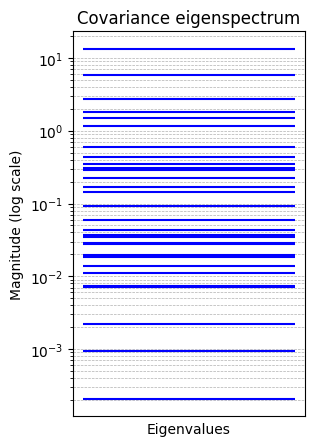

In [ ]:
# Number of eigenvalues
num_eigenvalues = len(C_eigenvalues_sorted)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 5))

# Plot horizontal lines for each eigenvalue
for i in range(num_eigenvalues):
    ax.hlines(y=C_eigenvalues_sorted[i], xmin=0, xmax=1, color='b')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set labels and title
ax.set_title('Covariance eigenspectrum')
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Magnitude (log scale)')
ax.set_xticks([])  # Remove x-ticks as they are not informative in this context

# Show grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.show()

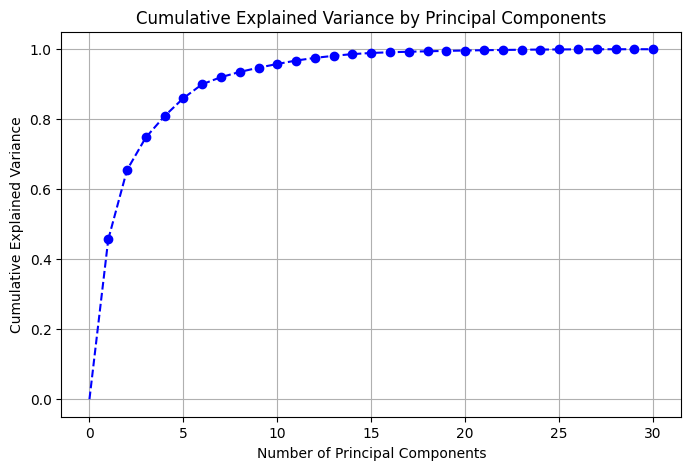

In [ ]:
# Calculate the explained variance ratio for each eigenvalue
explained_variance_ratio = C_eigenvalues_sorted / np.sum(C_eigenvalues_sorted)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Add 0 at the beginning of the cumulative explained variance array
cumulative_explained_variance = np.insert(cumulative_explained_variance, 0, 0)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_explained_variance)), cumulative_explained_variance[1:], marker='o', linestyle='--', color='b')
plt.plot([0, 1], [0, cumulative_explained_variance[1]], linestyle='--', color='b')  # Connect the first point with the origin
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)

### The contribution of the parameters to the first covariance eigenvector

The horizontal bar plot will illustrate the relative importance of each parameter in influencing the first eigenvector of the covariance matrix. Parameters with higher contributions have a greater impact on the first eigenvector and play a crucial role in distinguishing different classes within the dataset.

#### <font color=#FF5F1F><b>Figure C</b></font>

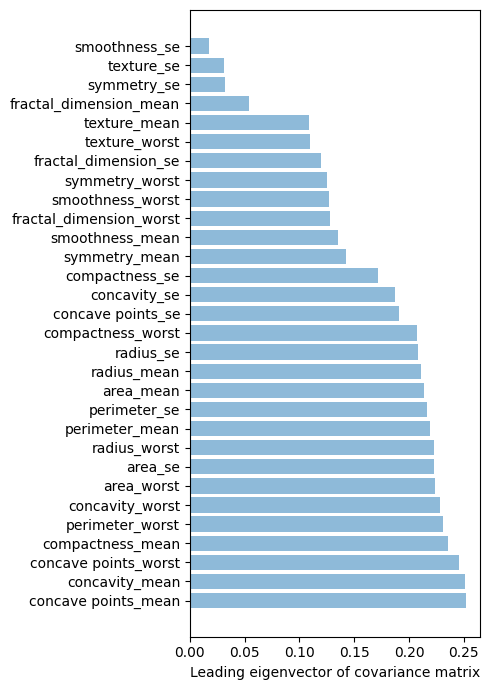

In [ ]:
# Calculate the absolute values of the elements in the first eigenvector of the Covariance matrix
C_first_eigenvector = abs(C_eigenvectors_sorted[:, 0])

# Define parameter names
param_names = [column_index_map[i] for i in range(30)]


# Sort the parameters by their absolute contributions
sorted_indices = np.argsort(np.abs(C_first_eigenvector))[::-1]
sorted_param_names = [param_names[i] for i in sorted_indices]
sorted_contributions = C_first_eigenvector[sorted_indices]

# Create a horizontal bar plot
plt.figure(figsize=(5, 7))
y_pos = np.arange(len(sorted_param_names))
plt.barh(y_pos, sorted_contributions, align="center", alpha=0.5)
plt.yticks(y_pos, sorted_param_names)
plt.xlabel("Leading eigenvector of covariance matrix")

# Display the plot
plt.tight_layout()
plt.show()

## Hessian matrix and its eigenanalysis

Our Hessian matrix is evaluated on a deep learning model trained on the same training set. The expected Hessian matrix is given by:

$$\mathrm{H}_\theta = - \frac{1}{n} \sum_{i=1}^n \left[\nabla_\theta^2 \log p_\theta(c_i \mid x_i) \right]$$

The Hessian matrix provides information about the curvature and landscape of the loss function with respect to the model parameters. Eigenanalysis of the Hessian matrix allows us to extract the most discriminative directions that separate different classes.

### Deep learning model training and evaluation

We employ a deep neural network architecture consisting of four fully connected layers, each followed by a Rectified Linear Unit (ReLU) activation. The final layer employs a sigmoid activation function to yield a probability value within the range of 0 to 1. During training, we utilize the binary cross-entropy loss function along with the Adam optimizer. Addressing the class imbalance issue, we resample the training dataset using the RandomOverSampler technique.

In [ ]:
# Define the neural network model
class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


# Create a custom dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Resample the training set using RandomOverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(train_X, train_y)


# Set the random seed
torch.manual_seed(18)

# Create data loaders for training and test sets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Instantiate the model and the optimizer
model = MyModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters())

# Train the model
num_epochs = 1000
criterion = nn.BCELoss()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

# Evaluate the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_pred_proba = model(X_test_tensor).detach().numpy()
y_pred = (y_pred_proba >= 0.5).astype(int)
auc_roc = roc_auc_score(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("Precision:", precision)
print("F1 score:", f1score)

# Print evaluation metrics
print("AUC ROC:", auc_roc)
print("Cohen Kappa Score:", cohen_kappa)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Geometric Mean Score:", gmean)

Confusion Matrix:
[[107   1]
 [  1  62]]
Precision: 0.9841269841269841
Recall: 0.9841269841269841
Precision: 0.9841269841269841
F1 score: 0.9841269841269841
AUC ROC: 0.9916960611405056
Cohen Kappa Score: 0.9748677248677249
Accuracy: 0.9883040935672515
Geometric Mean Score: 0.9874283251137367


In [ ]:
# Set the model to evaluation mode
model.eval()

# Compute the average Hessian matrix
hessian_sum = None
for i in range(len(train_X)):
    x = torch.tensor(train_X.iloc[i].values, dtype=torch.float32)
    y = torch.tensor([train_y.iloc[i]], dtype=torch.float32)

    hessian_matrix = hessian(lambda inputs: criterion(model(inputs), y), x)

    if hessian_sum is None:
        hessian_sum = hessian_matrix
    else:
        hessian_sum += hessian_matrix

hessian_matrix_avg = hessian_sum / len(train_X)

#### <font color=#FF5F1F><b>Figure D</b></font>

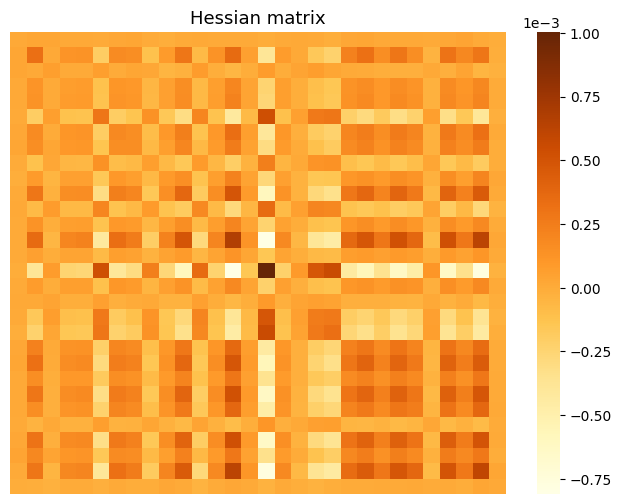

In [ ]:
# Visualize the Hessian matrix as a heatmap
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8, 6))

heatmap = sns.heatmap(hessian_sum, annot=False, cmap='YlOrBr', xticklabels=False, yticklabels=False)

# Customize colorbar to use scientific notation
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=10)  # Set label size
colorbar.ax.yaxis.set_major_formatter(plt.ScalarFormatter())
colorbar.ax.yaxis.get_major_formatter().set_scientific(True)
colorbar.ax.yaxis.get_major_formatter().set_powerlimits((-2, 2))

plt.title('Hessian matrix', fontsize=13)
plt.show()


In [ ]:
# Perform eigenanalysis on the Hessian matrix

H = hessian_sum.numpy()
H_eigenvalues, H_eigenvectors = np.linalg.eig(H)
H_eigenvectors = np.real(H_eigenvectors)

In [ ]:
# Sort Hessian eigenvalues and corresponding eigenvectors in descending order
# The 'H_eigenvalues_sorted' array contains the Hessian eigenvalues sorted in descending order,
# while the 'H_eigenvectors_sorted' array contains the corresponding Hessian eigenvectors with the same sorting.

sorted_indices = np.argsort(H_eigenvalues)[::-1]
H_eigenvalues_sorted = H_eigenvalues[sorted_indices]
H_eigenvectors_sorted = H_eigenvectors[:, sorted_indices]

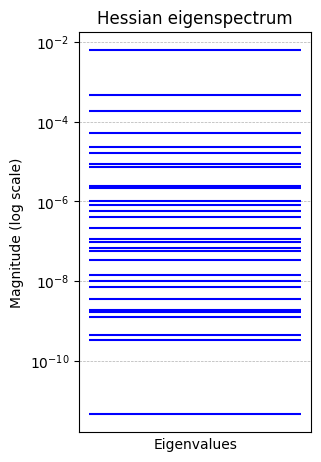

In [ ]:
# Number of eigenvalues
num_eigenvalues = len(H_eigenvalues_sorted)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 5.2))

# Plot horizontal lines for each eigenvalue
for i in range(num_eigenvalues):
    ax.hlines(y=H_eigenvalues_sorted[i], xmin=0, xmax=1, color='b')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set labels and title
ax.set_title('Hessian eigenspectrum')
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Magnitude (log scale)')
ax.set_xticks([])

# Show grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.show()

### The contribution of the parameters to the first Hessian eigenvector

The horizontal bar plot will illustrate the relative importance of each parameter in influencing the first eigenvector of the Hessian matrix. Parameters with higher contributions have a greater impact on the first eigenvector and play a crucial role in distinguishing different classes within the dataset.

#### <font color=#FF5F1F><b>Figure E</b></font>

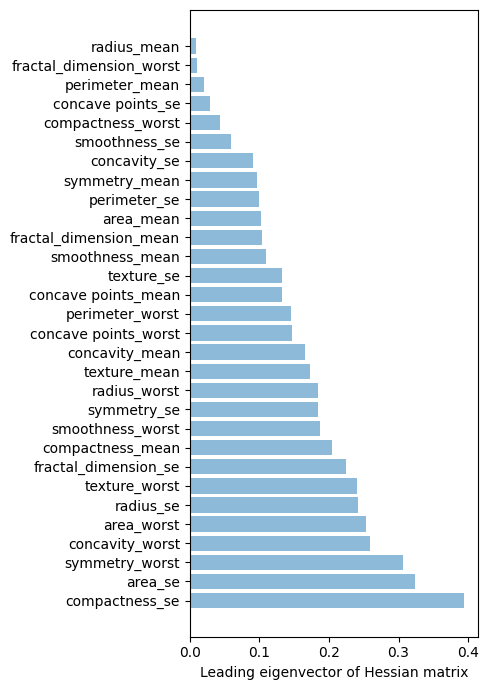

In [ ]:
# Calculate the absolute values of the elements in the first eigenvector of the Hessian matrix
H_first_eigenvector = abs(H_eigenvectors_sorted[:, 0])

# Define parameter names
param_names = [column_index_map[i] for i in range(30)]


# Sort the parameters by their absolute contributions
sorted_indices = np.argsort(np.abs(H_first_eigenvector))[::-1]
sorted_param_names = [param_names[i] for i in sorted_indices]
sorted_contributions = H_first_eigenvector[sorted_indices]

# Create a horizontal bar plot
plt.figure(figsize=(5, 7))
y_pos = np.arange(len(sorted_param_names))
plt.barh(y_pos, sorted_contributions, align="center", alpha=0.5)
plt.yticks(y_pos, sorted_param_names)
plt.xlabel("Leading eigenvector of Hessian matrix")

# Display the plot
plt.tight_layout()
plt.show()

## Holdout validation

### Proposed method

In [ ]:
# Compute 30-dimensional projections using H_eigenvectors_sorted
H_train_proj = np.dot(train_X, H_eigenvectors_sorted[:, :30])
H_train_proj = H_train_proj / H_train_proj.std(axis=0)

# Compute 30-dimensional projections using C_eigenvectors_sorted
C_train_proj = np.dot(train_X, C_eigenvectors_sorted[:, :30])

In [ ]:
# Compute 30-dimensional projections using H_eigenvectors_sorted
H_test_proj = np.dot(X_test, H_eigenvectors_sorted[:, :30])
H_test_proj = H_test_proj / H_test_proj.std(axis=0)

# Compute 30-dimensional projections using C_eigenvectors_sorted
C_test_proj = np.dot(X_test, C_eigenvectors_sorted[:, :30])

In [ ]:
# Separate features and target variable
X_train_proj = np.stack((C_train_proj[:,0], H_train_proj[:,0]), axis=1)

X_test_proj = np.stack((C_test_proj[:,0], H_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_train_pred = classifier.predict(X_train_proj)
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure F</b></font>

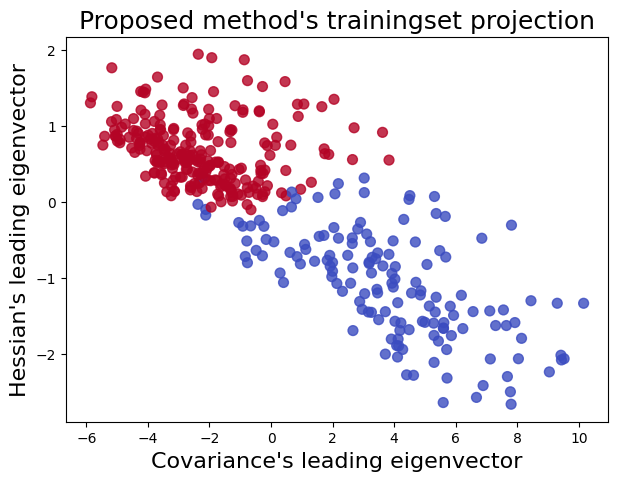

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

plt.figure(figsize=(7, 5))

plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian's leading eigenvector", fontsize=16)
plt.xlabel("Covariance's leading eigenvector", fontsize=16)
plt.title("Proposed method's trainingset projection", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for training sets

test_acc = accuracy_score(train_y, y_train_pred)
test_precision = precision_score(train_y, y_train_pred)
test_recall = recall_score(train_y, y_train_pred)
test_f1 = f1_score(train_y, y_train_pred)
test_roc_auc = roc_auc_score(train_y, y_train_pred)
test_kappa = cohen_kappa_score(train_y, y_train_pred)


# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(train_y.values, y_train_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)


Test set metrics:
Confusion Matrix:
[[248   1]
 [  6 143]]
Accuracy: 0.9824120603015075
Precision: 0.9930555555555556
Recall: 0.959731543624161
F1 score: 0.9761092150170648
ROC AUC score: 0.9778577396835664


#### <font color=#FF5F1F><b>Figure G</b></font>

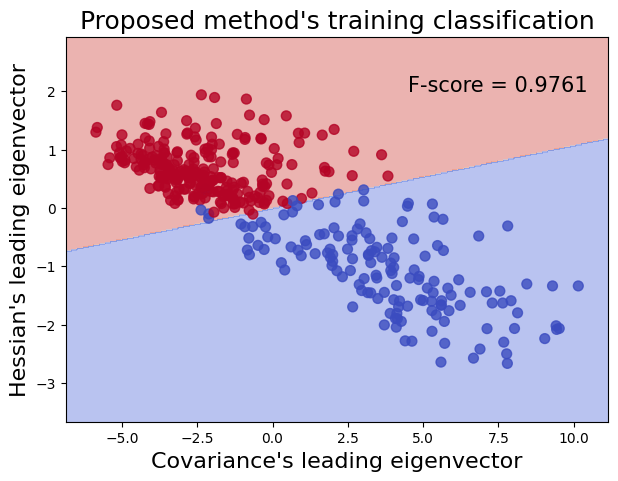

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.text(4.5, 2, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.ylabel("Hessian's leading eigenvector", fontsize=16)
plt.xlabel("Covariance's leading eigenvector", fontsize=16)
plt.title("Proposed method's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure H</b></font>

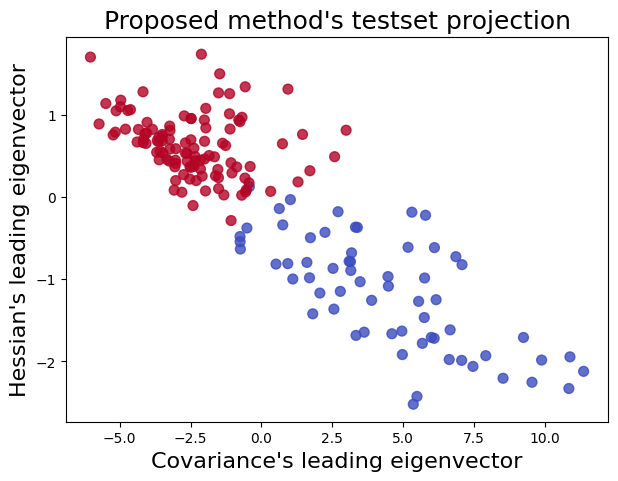

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

plt.figure(figsize=(7, 5))

plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian's leading eigenvector", fontsize=16)
plt.xlabel("Covariance's leading eigenvector", fontsize=16)
plt.title("Proposed method's testset projection", fontsize=18)
plt.show()

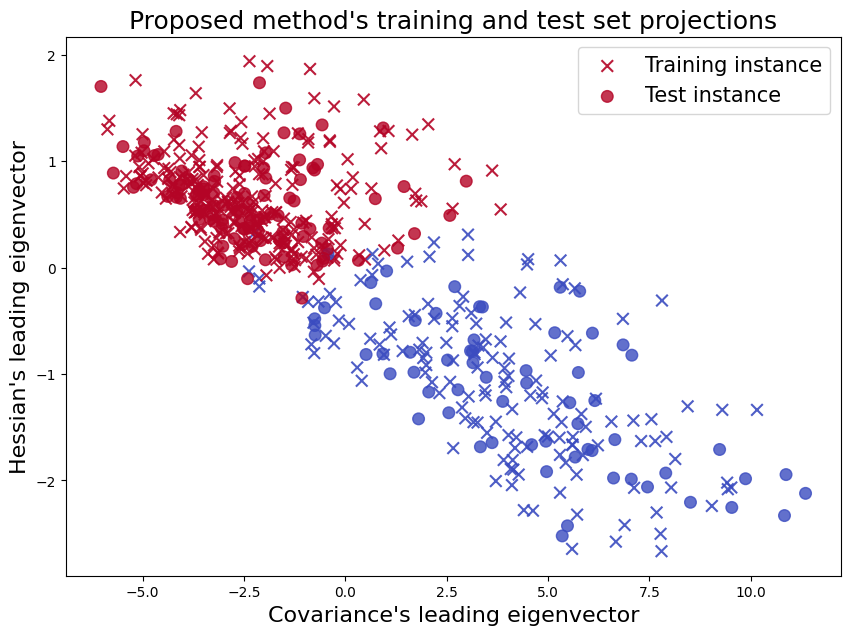

In [ ]:
# Assuming X_train_proj and X_test_proj are already defined and contain the projections
# Convert to DataFrames
X_train_proj = pd.DataFrame(X_train_proj)
X_test_proj = pd.DataFrame(X_test_proj)

# Create a single plot
plt.figure(figsize=(10, 7))

# Plot training data with default dot symbols
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.9,
    cmap="coolwarm_r",
    s=70,
    marker='x',  # Use square markers for testing set
    label="Training instance",
)

# Plot testing data with square symbols
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=70,
    label="Test instance"
)

# Labels and title
plt.ylabel("Hessian's leading eigenvector", fontsize=16)
plt.xlabel("Covariance's leading eigenvector", fontsize=16)
plt.title("Proposed method's training and test set projections", fontsize=18)

# Add a legend to differentiate between training and testing sets
plt.legend(fontsize=15)
plt.show()


In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

proposed_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[107   1]
 [  1  62]]
Accuracy: 0.9883040935672515
Precision: 0.9841269841269841
Recall: 0.9841269841269841
F1 score: 0.9841269841269841
ROC AUC score: 0.9874338624338624
Cohen's kappa score: 0.9748677248677249


#### <font color=#FF5F1F><b>Figure I</b></font>

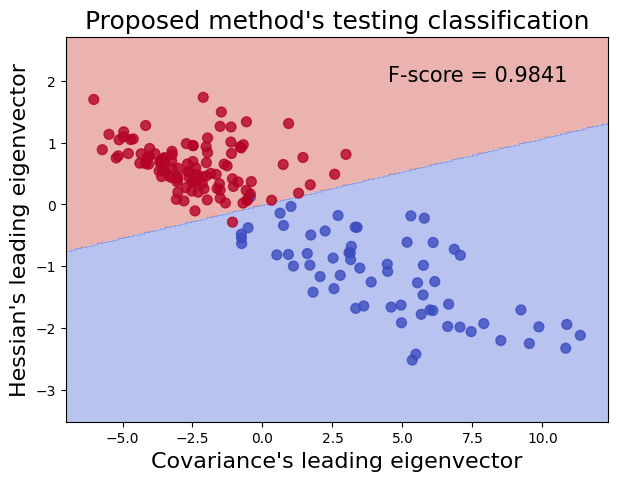

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)

plt.text(4.5, 2, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.ylabel("Hessian's leading eigenvector", fontsize=16)
plt.xlabel("Covariance's leading eigenvector", fontsize=16)
plt.title("Proposed method's testing classification", fontsize=18)
plt.show()

### Hessian method

In [ ]:
# Separate features and target variable
X_train_proj = np.stack((H_train_proj[:,1], H_train_proj[:,0]), axis=1)

X_test_proj = np.stack((H_test_proj[:,1], H_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_train_pred = classifier.predict(X_train_proj)
y_test_pred = classifier.predict(X_test_proj)


In [ ]:
# Calculate evaluation metrics for training sets

test_acc = accuracy_score(train_y, y_train_pred)
test_precision = precision_score(train_y, y_train_pred)
test_recall = recall_score(train_y, y_train_pred)
test_f1 = f1_score(train_y, y_train_pred)
test_roc_auc = roc_auc_score(train_y, y_train_pred)
test_kappa = cohen_kappa_score(train_y, y_train_pred)


# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(train_y.values, y_train_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)


Test set metrics:
Confusion Matrix:
[[246   3]
 [  6 143]]
Accuracy: 0.9773869346733668
Precision: 0.9794520547945206
Recall: 0.959731543624161
F1 score: 0.9694915254237289
ROC AUC score: 0.9738416754265383


#### <font color=#FF5F1F><b>Figure J</b></font>

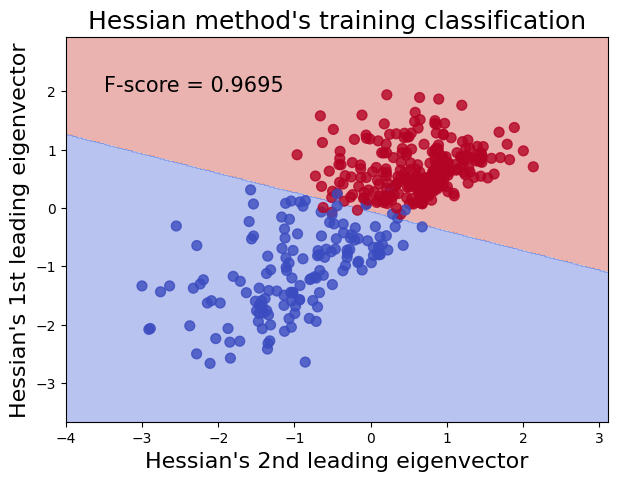

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.text(-3.5, 2, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.ylabel("Hessian's 1st leading eigenvector", fontsize=16)
plt.xlabel("Hessian's 2nd leading eigenvector", fontsize=16)
plt.title("Hessian method's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure L</b></font>

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

hessian_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[105   3]
 [  1  62]]
Accuracy: 0.9766081871345029
Precision: 0.9538461538461539
Recall: 0.9841269841269841
F1 score: 0.96875
ROC AUC score: 0.9781746031746033
Cohen's kappa score: 0.9500657030223391


#### <font color=#FF5F1F><b>Figure K</b></font>

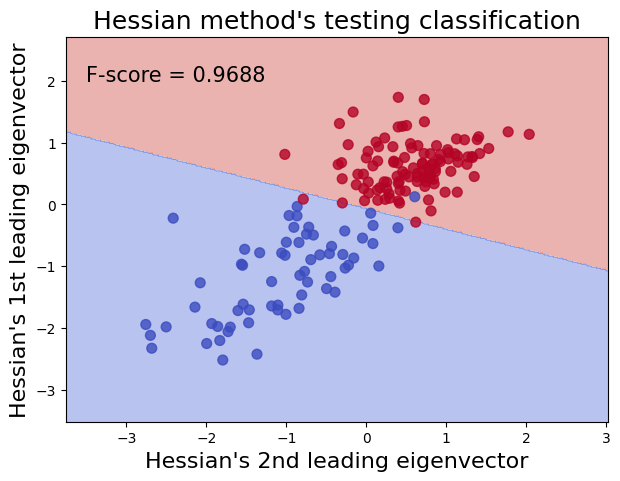

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.text(-3.5, 2, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.ylabel("Hessian's 1st leading eigenvector", fontsize=16)
plt.xlabel("Hessian's 2nd leading eigenvector", fontsize=16)
plt.title("Hessian method's testing classification", fontsize=18)
plt.show()

### PCA

In [ ]:
# Separate features and target variable
X_train_proj = np.stack((C_train_proj[:,1], C_train_proj[:,0]), axis=1)

X_test_proj = np.stack((C_test_proj[:,1], C_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_train_pred = classifier.predict(X_train_proj)
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure M</b></font>

In [ ]:
# Calculate evaluation metrics for training sets

test_acc = accuracy_score(train_y, y_train_pred)
test_precision = precision_score(train_y, y_train_pred)
test_recall = recall_score(train_y, y_train_pred)
test_f1 = f1_score(train_y, y_train_pred)
test_roc_auc = roc_auc_score(train_y, y_train_pred)
test_kappa = cohen_kappa_score(train_y, y_train_pred)


# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(train_y.values, y_train_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)


Test set metrics:
Confusion Matrix:
[[238  11]
 [ 11 138]]
Accuracy: 0.9447236180904522
Precision: 0.9261744966442953
Recall: 0.9261744966442953
F1 score: 0.9261744966442953
ROC AUC score: 0.940998894908493


#### <font color=#FF5F1F><b>Figure L</b></font>

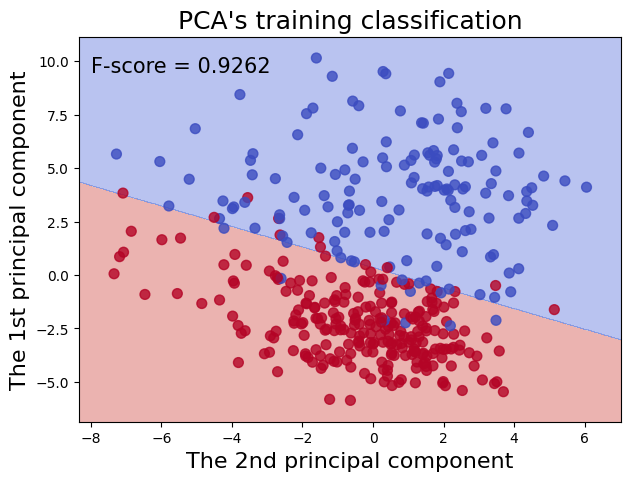

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.text(-8, 9.5, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.ylabel("The 1st principal component", fontsize=16)
plt.xlabel("The 2nd principal component", fontsize=16)
plt.title("PCA's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure M</b></font>

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)


# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[106   2]
 [  3  60]]
Accuracy: 0.9707602339181286
Precision: 0.967741935483871
Recall: 0.9523809523809523
F1 score: 0.96
ROC AUC score: 0.966931216931217
Cohen's kappa score: 0.9369608493696084


#### <font color=#FF5F1F><b>Figure N</b></font>

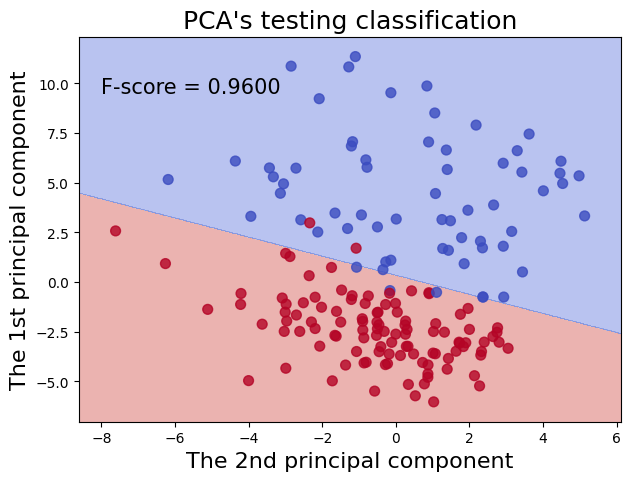

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)

plt.text(-8, 9.5, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.ylabel("The 1st principal component", fontsize=16)
plt.xlabel("The 2nd principal component", fontsize=16)
plt.title("PCA's testing classification", fontsize=18)
plt.show()

### UMAP

In [ ]:
# Define the target variable and the features
target = train_y
features = train_X

# Create a supervised UMAP object
umap_supervised = umap.UMAP(
    n_neighbors=20, n_components=2, metric="euclidean", random_state=23
)

# Fit the UMAP model with the features and target variable
embedding = umap_supervised.fit_transform(features, y=target)

In [ ]:
# Separate features and target variable
X_train_umap = pd.DataFrame(embedding)
y_train_umap = target

X_test_umap = umap_supervised.transform(X_test)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_umap, target)

# Make predictions on the training and test sets
y_train_pred = classifier.predict(X_train_umap)
y_test_pred = classifier.predict(X_test_umap)

#### <font color=#FF5F1F><b>Figure O</b></font>

In [ ]:
# Calculate evaluation metrics for training sets

test_acc = accuracy_score(y_train_umap, y_train_pred)
test_precision = precision_score(y_train_umap, y_train_pred)
test_recall = recall_score(y_train_umap, y_train_pred)
test_f1 = f1_score(y_train_umap, y_train_pred)
test_roc_auc = roc_auc_score(y_train_umap, y_train_pred)
test_kappa = cohen_kappa_score(y_train_umap, y_train_pred)

umap_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets
print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_train_umap.values, y_train_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[249   0]
 [  0 149]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
ROC AUC score: 1.0
Cohen's kappa score: 1.0


#### <font color=#FF5F1F><b>Figure O</b></font>

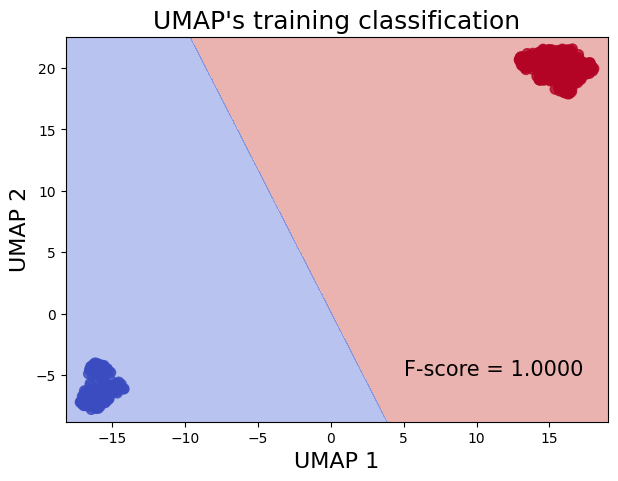

In [ ]:
X_train_proj = X_train_umap

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=y_train_umap,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.text(5, -5, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.xlabel("UMAP 1", fontsize=16)
plt.ylabel("UMAP 2", fontsize=16)
plt.title("UMAP's training classification", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

umap_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets
print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[107   1]
 [  7  56]]
Accuracy: 0.9532163742690059
Precision: 0.9824561403508771
Recall: 0.8888888888888888
F1 score: 0.9333333333333333
ROC AUC score: 0.9398148148148148
Cohen's kappa score: 0.8974358974358975


#### <font color=#FF5F1F><b>Figure P</b></font>

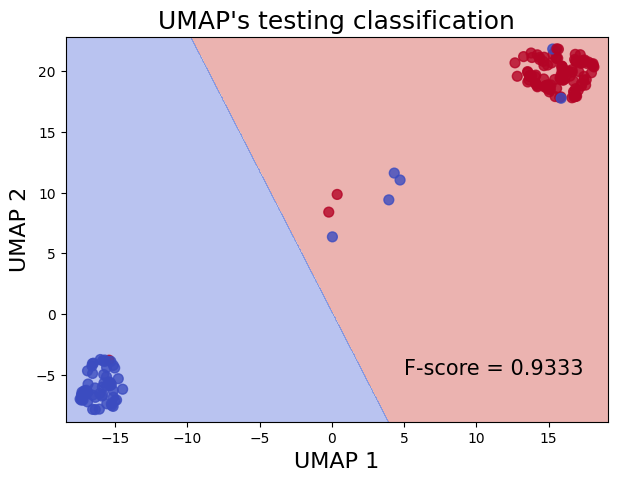

In [ ]:
X_test_proj = pd.DataFrame(X_test_umap)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
scatter = plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
    label="Test Data"  # Label for the scatter points
)

plt.text(5, -5, f'F-score = {test_f1:.4f}', fontsize=15, color='black')
plt.xlabel("UMAP 1", fontsize=16)
plt.ylabel("UMAP 2", fontsize=16)
plt.title("UMAP's testing classification", fontsize=18)

plt.show()


### Linear discriminant analysis (LDA)

In [ ]:
# Creating an instance of the LDA class
lda = LinearDiscriminantAnalysis()

# Fitting the LDA model to the data
lda.fit(train_X, train_y)

# Transforming the data to the LDA space
X_lda = lda.transform(train_X)

In [ ]:
# Fit the SVM model to the training data
svm = SVC(kernel="linear")
svm.fit(X_lda, train_y)

# Extract hyperplane coefficients
w = svm.coef_[0]
b = svm.intercept_[0]

# Make predictions on the train data
y_pred = svm.predict(X_lda) # Create a plot of the embedding with the target variable as color

In [ ]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(train_y, y_pred)
accuracy = accuracy_score(train_y, y_pred)
precision = precision_score(train_y, y_pred)
recall = recall_score(train_y, y_pred)
f1 = f1_score(train_y, y_pred)
roc_auc = roc_auc_score(train_y, y_pred)
cohen_kappa = cohen_kappa_score(train_y, y_pred)

lda_eval = [
    precision,
    recall,
    f1,
    roc_auc,
    cohen_kappa,
]

# Print the evaluation metrics

print("Test set metrics:")
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)
print("Cohen's kappa score:", cohen_kappa)

Test set metrics:
Confusion Matrix:
 [[246   3]
 [  5 144]]
Accuracy: 0.9798994974874372
Precision: 0.9795918367346939
Recall: 0.9664429530201343
F1 score: 0.9729729729729729
ROC AUC score: 0.9771973801245248
Cohen's kappa score: 0.9569741358341667


#### <font color=#FF5F1F><b>Figure Q</b></font>

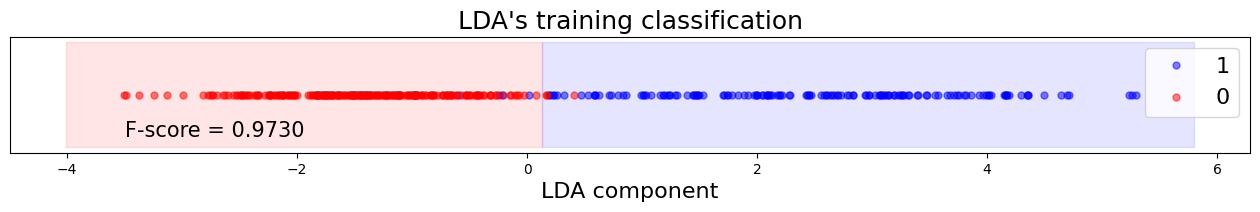

In [ ]:
# Create a plot of the embedding with the target variable as color
positive = X_lda[train_y == 1]
negative = X_lda[train_y == 0]

# Find the midpoint between the rightmost blue point and the leftmost red point
midpoint = -b / w

plt.figure(figsize=(16, 1.5))

plt.plot(
    positive[:, 0],
    np.zeros_like(positive[:, 0]),
    "bo",
    alpha=0.5,
    label="1",
    markersize=5,
)
plt.plot(
    negative[:, 0],
    np.zeros_like(negative[:, 0]),
    "ro",
    alpha=0.5,
    label="0",
    markersize=5,
)


# Shade the areas on either side of the midpoint
if np.mean(positive[:, 0]) < np.mean(negative[:, 0]):
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(positive[:, 0]) - 0.5, color="blue", alpha=0.1
  )
  plt.fill_betweenx(
      [-5, 5], np.max(negative[:, 0]) + 0.5, midpoint, color="red", alpha=0.1
  )
else:
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(negative[:, 0]) - 0.5, color="red", alpha=0.1
  )
  plt.fill_betweenx(
      [-5, 5], np.max(positive[:, 0]) + 0.5, midpoint, color="blue", alpha=0.1
  )

plt.text(-3.5, -4, f'F-score = {f1:.4f}', fontsize=15, color='black')

# Add a vertical line at the midpoint
# plt.axvline(midpoint, color='k', linestyle='--')

plt.title(f"LDA's training classification", fontsize=18)
plt.xlabel("LDA component", fontsize=16)
plt.legend(fontsize=16)
plt.gca().get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Make predictions on the test data
X_lda_test = lda.transform(X_test)
y_pred = svm.predict(X_lda_test)# Create a plot of the embedding with the target variable as color

In [ ]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

lda_eval = [
    precision,
    recall,
    f1,
    roc_auc,
    cohen_kappa,
]

# Print the evaluation metrics

print("Test set metrics:")
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)
print("Cohen's kappa score:", cohen_kappa)

Test set metrics:
Confusion Matrix:
 [[103   5]
 [  4  59]]
Accuracy: 0.9473684210526315
Precision: 0.921875
Recall: 0.9365079365079365
F1 score: 0.9291338582677166
ROC AUC score: 0.9451058201058201
Cohen's kappa score: 0.8872775214238628


#### <font color=#FF5F1F><b>Figure R</b></font>

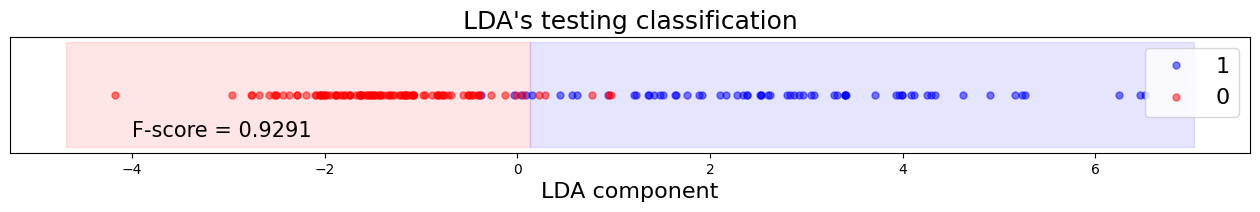

In [ ]:
# Create a plot of the embedding with the target variable as color
positive = X_lda_test[y_test == 1]
negative = X_lda_test[y_test == 0]

# Find the midpoint between the rightmost blue point and the leftmost red point
midpoint = -b / w

plt.figure(figsize=(16, 1.5))

plt.plot(
    positive[:, 0],
    np.zeros_like(positive[:, 0]),
    "bo",
    alpha=0.5,
    label="1",
    markersize=5,
)
plt.plot(
    negative[:, 0],
    np.zeros_like(negative[:, 0]),
    "ro",
    alpha=0.5,
    label="0",
    markersize=5,
)


# Shade the areas on either side of the midpoint
if np.mean(positive[:, 0]) < np.mean(negative[:, 0]):
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(positive[:, 0]) - 0.5, color="blue", alpha=0.1
  )
  plt.fill_betweenx(
      [-5, 5], np.max(negative[:, 0]) + 0.5, midpoint, color="red", alpha=0.1
  )
else:
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(negative[:, 0]) - 0.5, color="red", alpha=0.1
  )
  plt.fill_betweenx(
      [-5, 5], np.max(positive[:, 0]) + 0.5, midpoint, color="blue", alpha=0.1
  )


plt.text(-4, -4, f'F-score = {f1:.4f}', fontsize=15, color='black')

# Add a vertical line at the midpoint

plt.title(f"LDA's testing classification", fontsize=18)
plt.xlabel("LDA component", fontsize=16)
plt.legend(fontsize=16)
plt.gca().get_yaxis().set_visible(False)
plt.show()